In [1]:
from IBA.tensorflow_v1 import IBALayer, to_saliency_map
from gernerate_data import load_clas_seg_data, load_clas_seg_data_for_test
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model, Model
from models.MTL_IBA import MTL_IBA_cross3
from keras.utils.np_utils import *
import matplotlib.pyplot as plt
from keras.layers import *
import matplotlib as mpl
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle
import cv2
import os


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
from keras.layers.normalization import BatchNormalization


img_size = 224
depth = 3
target = (img_size, img_size)

Name =  'MTL_IBA_bit'
save_dir = 'dataset/prediction/Dataset_BUSI_AN/' + Name
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
       

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
   


def remove_iba(model):
    
#     c = BatchNormalization()(model.get_layer('block4_c_conv3').output,  training=False)
    c = MaxPooling2D((2, 2), strides=(2, 2), name='block4_c_pool')(model.get_layer('block4_c_conv3').output)
     
    # classification block 5
    c = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_c_conv1')(c)
    c = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_c_conv2')(c)
    c = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_c_conv3')(c)
#     c = BatchNormalization()(block5_c_conv3, training=False)
    block5_c_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block5_c_pool')(c)
     
    c = Flatten(name='cls_flatten')(block5_c_pool)
    c = Dense(64, name='cls_dense_0', activation='relu',)(c)
#     c = Activation('relu', name='cls_act_3')(c)
    c = Dropout(0.5, name='cls_dropout')(c)
    c = Dense(2, name='cls_dense_out', activation='softmax')(c)

    logits_model = Model(inputs=model.input, outputs=c)
    
    return logits_model

In [3]:
# 加载数据
trainX_dir = 'dataset/Dataset_BUSI_AN/train/images/'
valX_dir = 'dataset/Dataset_BUSI_AN/val/images/'
testX_dir = 'dataset/Dataset_BUSI_AN/test/images/'

train_x, train_c_y, train_s_y = load_clas_seg_data(trainX_dir, target)
val_x, val_c_y, val_s_y = load_clas_seg_data(valX_dir, target)
test_x, test_c_y, test_s_y, test_images_names, images = load_clas_seg_data_for_test(testX_dir, target,  shuffle=False)

lb = LabelBinarizer()
train_c_y = lb.fit_transform(train_c_y)
train_c_y = to_categorical(train_c_y, 2)
val_c_y = lb.fit_transform(val_c_y)
val_c_y = to_categorical(val_c_y, 2)
test_c_y = lb.fit_transform(test_c_y)
test_c_y = to_categorical(test_c_y, 2)


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import imp
import os
import sys

# catch exception with: except Exception as e
from builtins import filter, map, range, zip
from io import open

import keras.backend
import keras.models
import keras.preprocessing.image
import keras.utils
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import six
from future.utils import raise_from, raise_with_traceback

import innvestigate
import innvestigate.tools
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.imagenet
import innvestigate.utils.visualizations as ivis


base_dir = os.path.dirname(os.path.realpath("__file__"))
eutils = imp.load_source("utils", os.path.join(base_dir, "utils.py"))

In [5]:
# from keras.applications.vgg16 import preprocess_input, decode_predictions


# steps = 8
# gpu_count = len(os.environ.get("CUDA_VISIBLE_DEVICES", "").split(","))
# max_queue_size = 100
# workers = 4 * gpu_count
# use_multiprocessing = False
# print("GPU_COUNT", gpu_count)

###########################################################################
# Build model.
###########################################################################
#     tmp = getattr(innvestigate.applications.imagenet, netname)
#     net = tmp(load_weights=True)

base_model = MTL_IBA_cross3(img_size, img_size, depth, nClasses=2)
model = remove_iba(base_model)
model.load_weights('MTL-IBA.h5', by_name=True)
# model.summary()

opt = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.01)    
model.compile(optimizer=opt, loss="categorical_crossentropy")
    

modelp = keras.models.Model(inputs=model.input, outputs=model.get_layer('cls_dense_out').output)
modelp.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])


Instructions for updating:
Colocations handled automatically by placer.
lamb################################# Tensor("iba/Sigmoid:0", shape=(1, 28, 28, 256), dtype=float32)
Z_with_passing################################# Tensor("iba/mul_6:0", shape=(?, 28, 28, 256), dtype=float32)
output################################# Tensor("iba/cond_2/Merge:0", shape=(?, 28, 28, 256), dtype=float32)


2022-04-21 06:40:52.761988: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-21 06:40:52.797210: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200095000 Hz
2022-04-21 06:40:52.801695: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x14c0bdb0 executing computations on platform Host. Devices:
2022-04-21 06:40:52.801793: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-04-21 06:40:53.315923: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x14cb7b80 executing computations on platform CUDA. Devices:
2022-04-21 06:40:53.315997: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-04-21 06:40:53.317236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1433] Found device 0 with properties: 
name: T

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
###########################################################################
# Create data loaders.
###########################################################################
steps = 8

if keras.backend.image_data_format() == "channels_first":
    target_size = [224, 224]
else:
    target_size = [224, 224]

In [12]:
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

def preprocess(X):
    X = X.copy()
    X = preprocess_input(X)
    
    return X

def postprocess(X):
    X = X.copy()
    X = iutils.postprocess_images(X)
    return X


# def show_img(X):
#     X = X.copy()
#     return ivis.project(X, absmax=255.0, input_is_positive_only=True)

def show_img(X):
    X = X.copy()
    X = X*255.0
    X = np.clip(X, 0, 255, out=None)
    
    return 


def bk_proj(X):
    X = ivis.clip_quantile(X, 1)
    return ivis.project(X)


def heatmap(X):
    # X = ivis.gamma(X, minamp=0, gamma=0.95)
    return ivis.heatmap(X)


def graymap(X):
    return ivis.graymap(np.abs(X), input_is_positive_only=True)


In [18]:
# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = eutils.create_preprocessing_f(train_x, input_range)

# Preprocess data
data = (
    train_x, train_c_y,
    test_x, train_s_y
)

num_classes = len(np.unique(data[1]))
print(num_classes)

label_to_class_name = [int(i) for i in range(num_classes)]
print(label_to_class_name)

# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       show_img,      "Input"),

#     # Function
#     ("gradient",              {"postprocess": "abs"},   graymap,        "Gradient"),
#     ("smoothgrad",            {"noise_scale": noise_scale,
#                                "postprocess": "square"},graymap,        "SmoothGrad"),

#     # Signal
#     ("deconvnet",             {},                       bk_proj,        "Deconvnet"),
#     ("guided_backprop",       {},                       bk_proj,        "Guided Backprop",),
    ("pattern.net",           {"pattern_type": "relu"}, bk_proj,        "PatternNet"),

    # Interaction
    ("pattern.attribution",   {"pattern_type": "relu"}, heatmap,        "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, heatmap,        "DeepTaylor"),
#     ("input_t_gradient",      {},                       heatmap,        "Input * Gradient"),
#     ("integrated_gradients",  {"reference_inputs": ri}, heatmap,        "Integrated Gradients"),
#     ("lrp.z",                 {},                       heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,        "LRP-Epsilon"),
]

2
[0, 1]


The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [16]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=8, verbose=1)
    analyzers.append(analyzer)

Epoch 1/1
125/125 [==============================] - 16s 127ms/step - loss: 15.0000 - broadcast_31_loss: 1.0000 - broadcast_32_loss: 1.0000 - broadcast_33_loss: 1.0000 - broadcast_34_loss: 1.0000 - broadcast_35_loss: 1.0000 - broadcast_36_loss: 1.0000 - broadcast_37_loss: 1.0000 - broadcast_38_loss: 1.0000 - broadcast_39_loss: 1.0000 - broadcast_40_loss: 1.0000 - broadcast_41_loss: 1.0000 - broadcast_42_loss: 1.0000 - broadcast_43_loss: 1.0000 - broadcast_44_loss: 1.0000 - broadcast_45_loss: 1.0000
Epoch 1/1
125/125 [==============================] - 17s 134ms/step - loss: 15.0000 - broadcast_46_loss: 1.0000 - broadcast_47_loss: 1.0000 - broadcast_48_loss: 1.0000 - broadcast_49_loss: 1.0000 - broadcast_50_loss: 1.0000 - broadcast_51_loss: 1.0000 - broadcast_52_loss: 1.0000 - broadcast_53_loss: 1.0000 - broadcast_54_loss: 1.0000 - broadcast_55_loss: 1.0000 - broadcast_56_loss: 1.0000 - broadcast_57_loss: 1.0000 - broadcast_58_loss: 1.0000 - broadcast_59_loss: 1.0000 - broadcast_60_loss:

Now we analyze each image with the different analyzers:

In [19]:
%%capture

n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 224, 224, 3])
text = []

# test_x = np.array(test_x)
# test_c_y = np.array(test_c_y)

for i in range(len(test_x[:n])):
    
    # Add batch axis.
    x = np.expand_dims(test_x[i], axis=0)
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    print(y_hat)
    
    # Save prediction info:
    text.append(("%s" % str(np.argmax(test_c_y[i])),    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % y_hat # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

TypeError: 'NoneType' object is not subscriptable

Next, we visualize the analysis results:

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

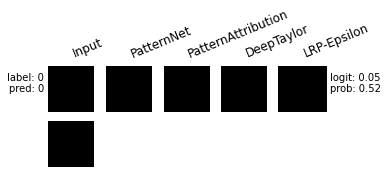

In [20]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]


# Prepare the labels
label, presm, prob, pred = zip(*text)

row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]


# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))

## 以下两个可以生成，但可能是错的 

In [10]:
import utils
# from utils import preprocess, postprocess

utils = imp.load_source('utils', './utils.py')

# Prepare analyzers
lrp_e = innvestigate.create_analyzer("lrp.epsilon", modelp)
lrp_zp = innvestigate.create_analyzer("lrp.z_plus", modelp)
lrp_pn = innvestigate.create_analyzer("pattern.net", modelp)
# lrp_pa = innvestigate.create_analyzer("pattern.attribution", modelp)
smoothgrad = innvestigate.create_analyzer("smoothgrad", modelp)
deep_taylor = innvestigate.create_analyzer("deep_taylor", modelp)
gradient = innvestigate.create_analyzer("gradient", modelp)



# Learn signals
# imgs = np.array(list(map(lambda x: x[0], images)))
lrp_pn.fit(train_x)

2022-04-21 03:00:42.273847: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


(64, 224, 224, 3)


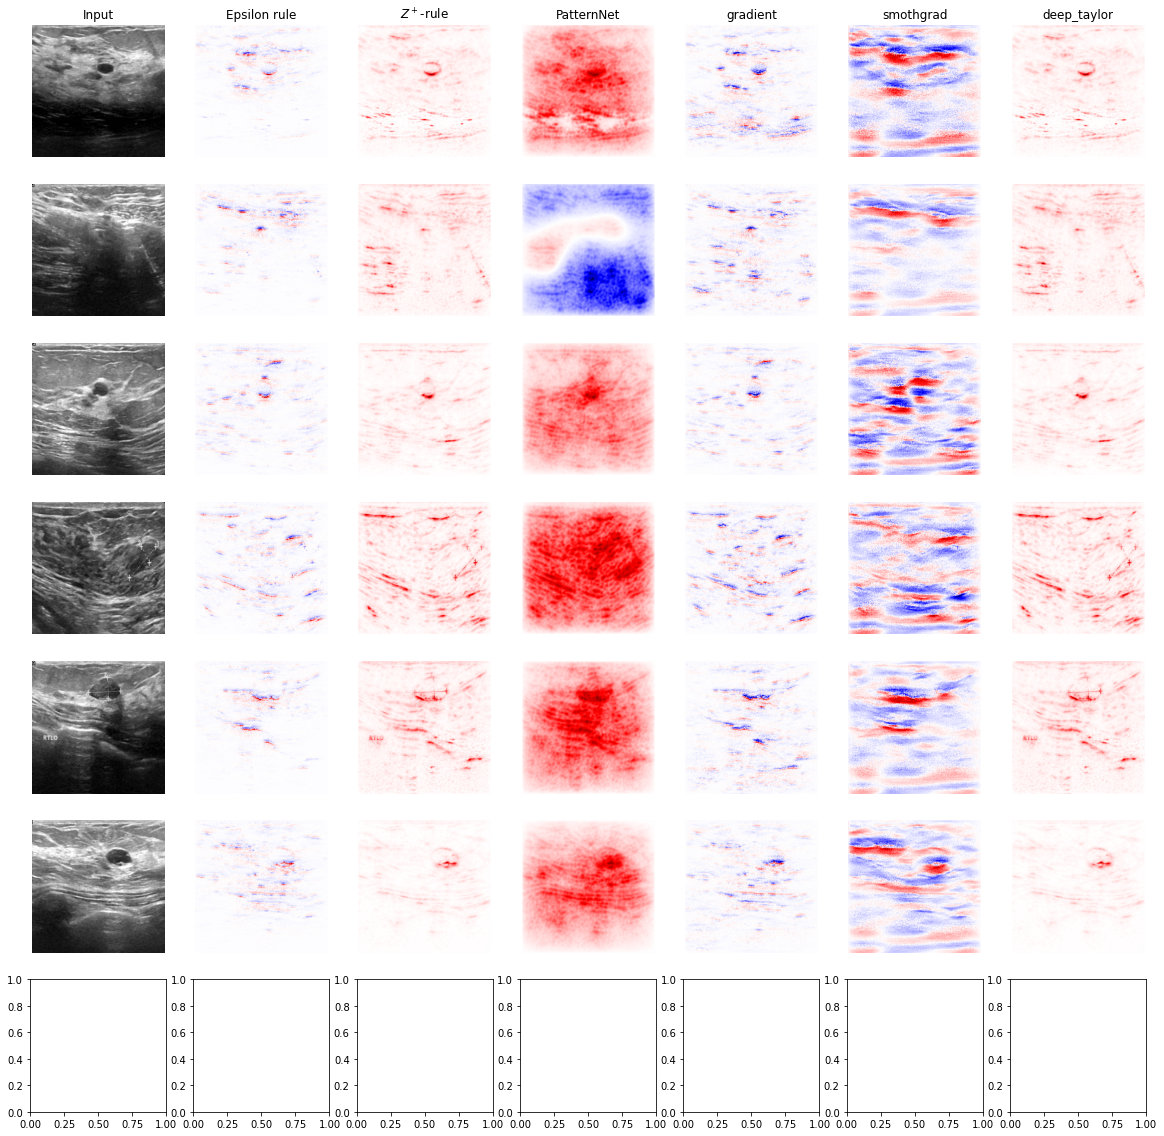

In [15]:
# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB"

#### PLOTTING STUFF ####
n_imgs = len(test_x)
figs, ax = plt.subplots(7, 7, figsize=(20,20))

print(test_x.shape)

for i in range(0,6):
    # Choose a sample image and add batch axis
    image = test_x[i]
    image_pp =  np.expand_dims(image, axis=0)

    #Preprocess it for VGG16
#     image_pp = preprocess(image)

    # Create analysis                                        <-- Only interesting thing in plot part
    a_e = lrp_e.analyze(image_pp)
    a_zp = lrp_zp.analyze(image_pp)
    a_pn = lrp_pn.analyze(image_pp)
#     a_pa = lrp_pa.analyze(image_pp)
    a_grad = gradient.analyze(image_pp) 
    a_smothgrad = smoothgrad.analyze(image_pp) 
    a_dt = deep_taylor.analyze(image_pp) 
    

    # Post process images
    a_e  = postprocess(a_e, color_conversion, channels_first)
    a_zp = postprocess(a_zp, color_conversion, channels_first)
    a_pn = postprocess(a_pn, color_conversion, channels_first)
#     a_pa = postprocess(a_pa, color_conversion, channels_first)
    a_grad = postprocess(a_grad, color_conversion, channels_first)
    a_smothgrad = postprocess(a_smothgrad, color_conversion, channels_first)
    a_dt = postprocess(a_dt, color_conversion, channels_first)
    
    ax[i][0].axis('off')
    ax[i][0].imshow(image)
    if i == 0: ax[i][0].set_title("Input")
    
    ax[i][1].axis('off')
    ax[i][1].imshow(image)
    ax[i][1].imshow(heatmap(a_e)[0])
    if i == 0: ax[i][1].set_title("Epsilon rule")
    
    ax[i][2].axis('off')
    ax[i][2].imshow(heatmap(a_zp)[0])
    if i == 0: ax[i][2].set_title("$Z^+$-rule")
    
    ax[i][3].axis('off')
    ax[i][3].imshow(heatmap(a_pn)[0])
    if i == 0: ax[i][3].set_title("PatternNet")
        
#     ax[i][4].axis('off')
#     ax[i][4].imshow(heatmap(a_pa)[0])
#     if i == 0: ax[i][3].set_title("PatternAttribution")
    
    ax[i][4].axis('off')
    ax[i][4].imshow(heatmap(a_grad)[0])
    if i == 0: ax[i][4].set_title("gradient")
    
    ax[i][5].axis('off')
    ax[i][5].imshow(heatmap(a_smothgrad)[0])
    if i == 0: ax[i][5].set_title("smothgrad")
    
    ax[i][6].axis('off')
    ax[i][6].imshow(heatmap(a_dt)[0])
    if i == 0: ax[i][6].set_title("deep_taylor")
        

## 保存PatternNet生成的归因图